In [1]:
import os
import sys
import json
import time 
import copy
import argparse
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

import SimpleITK as sitk
import tqdm
import pandas as pd 
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision import transforms
from torch.utils.data import DataLoader
from models import get_model
from data_loader.LiTS import LiTSDataset
from utils.train import ObjFromDict


def load_model(run_dir, metric='validation_dice'): 
    with open(os.path.join(run_dir,'config.json')) as json_file:
        config = json.load(json_file)
    config = ObjFromDict(config)
    model = get_model(config.model)
    checkpoint_path = os.path.join(run_dir, 'best_{}.pth'.format(metric)) 
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
    return model, config

def compute_dice(gt, pred): 
    eps = 1e-5
    intersection = np.sum(gt * pred)
    return ((2*  intersection) + eps)/ (eps + np.sum(gt+pred))

/home/raubyb/miniconda3/envs/MRIScoringEnv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raubyb/miniconda3/envs/MRIScoringEnv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raubyb/miniconda3/envs/MRIScoringEnv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [11]:
run_dir = 'runs/2020-03-28_21h11min'
model, config = load_model(run_dir,metric='0.7966')

feature_scale not specified in config, setting to default 4


In [12]:
device='cuda:0'
# device='cpu'

In [13]:
data_path = config.dataset.root
print('data_path ', data_path)

# fix the seed for the split
split_seed = 0 
np.random.seed(split_seed)

image_dir = os.listdir(os.path.join(data_path,'Training Batch 1')) + os.listdir(os.path.join(data_path,'Training Batch 2'))
all_indexes = [ int(file_name[7:-4]) for file_name in image_dir if 'volume' in file_name]
split = np.random.permutation(all_indexes)
n_train, n_val, n_test = int(0.8 * len(split)), int(0.1 * len(split)), int(0.1 * len(split))

train = split[: n_train]
val = split[n_train : n_train+n_val]
test = split[n_train + n_val :]


# Setup Data Loader
train_dataset = LiTSDataset(data_path, train, augment=True, no_tumor=True)
val_dataset = LiTSDataset(data_path, val, no_tumor=True)
test_dataset = LiTSDataset(data_path, test, no_tumor=True)
train_dataloader = DataLoader(dataset=train_dataset, num_workers=config.dataset.num_workers, batch_size=config.training.batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, num_workers=config.dataset.num_workers, batch_size=config.training.batch_size, shuffle=False)
test_dataloader  = DataLoader(dataset=test_dataset,  num_workers=config.dataset.num_workers, batch_size=config.training.batch_size, shuffle=False)



data_path  /home/raubyb/LiTS


In [14]:
batch_size=1
model = model.to(device)
model.eval()
dataset = LiTSDataset(data_path, test, physical_reference_size = (768, 768, 768), spacing=3, no_tumor=True, inference_mode=True)
dataloader = DataLoader(dataset=dataset, num_workers=0, batch_size=batch_size, shuffle=False)
dices = []
with torch.no_grad():
    for batch_idx, (data, target) in tqdm.tqdm(enumerate(dataloader)):
            
            data = data.to(device)
            output = model(data)
#             output = target["one_hot_target"]
            for i in range(batch_size):
                img = sitk.ReadImage(target['original_image_path'][i])
                normalization_transform = dataset.get_normalization_transform(img)
                inv_normalization_transform = normalization_transform.GetInverse()
                out_mask = np.round(output.cpu().numpy()[i,1,:,:,:])

                bb = target['bounding_box'].cpu().numpy()[i]

                ref_img = sitk.Resample(img, dataset.reference_image, normalization_transform)

                big_mask_numpy = sitk.GetArrayFromImage(ref_img)
                big_mask_numpy[:,:,:] = 0
                big_mask_numpy[bb[0]:bb[1],bb[2]:bb[3],bb[4]:bb[5]] = out_mask

                out_mask_image = sitk.GetImageFromArray(big_mask_numpy)
                out_mask_image.SetOrigin(ref_img.GetOrigin())
                out_mask_image.SetDirection(ref_img.GetDirection())
                out_mask_image.SetSpacing(ref_img.GetSpacing())
                out_mask_image_original_space = sitk.Resample(out_mask_image, img, inv_normalization_transform, sitk.sitkNearestNeighbor)
                original_mask = sitk.ReadImage(target['original_mask_path'][i])
                original_mask_array = np.clip(sitk.GetArrayFromImage(original_mask),0,1)
                out_mask_image_original_space_array = np.clip(sitk.GetArrayFromImage(out_mask_image_original_space),0,1)
                dice = compute_dice(out_mask_image_original_space_array, original_mask_array)
                dices.append(dice)

14it [00:45,  3.25s/it]


In [15]:
dices

[0.8277330101486452,
 0.891963428400311,
 0.9279038430754656,
 0.8741736182518189,
 0.3209655980898662,
 0.8328514962746602,
 0.9148269199175103,
 0.863011402233632,
 0.892840228934716,
 0.8094682863305144,
 0.851349544629782,
 0.3645754377335202,
 0.5397741763237182,
 0.8930660963758257]

In [17]:
np.mean(dices)

0.771750220479999

In [31]:
i=5
with torch.no_grad():
    data, target = dataset.__getitem__(i)

    data = data.unsqueeze(0).to(device)
    output = model(data)
    #             output = target["one_hot_target"]

    img = sitk.ReadImage(target['original_image_path'])
    normalization_transform = dataset.get_normalization_transform(img)
    inv_normalization_transform = normalization_transform.GetInverse()
    out_mask = np.round(output.cpu().numpy()[0,1,:,:,:])

    bb = target['bounding_box']

    ref_img = sitk.Resample(img, dataset.reference_image, normalization_transform)

    big_mask_numpy = sitk.GetArrayFromImage(ref_img)
    big_mask_numpy[:,:,:] = 0
    big_mask_numpy[bb[0]:bb[1],bb[2]:bb[3],bb[4]:bb[5]] = out_mask

    out_mask_image = sitk.GetImageFromArray(big_mask_numpy)
    out_mask_image.SetOrigin(ref_img.GetOrigin())
    out_mask_image.SetDirection(ref_img.GetDirection())
    out_mask_image.SetSpacing(ref_img.GetSpacing())
    out_mask_image_original_space = sitk.Resample(out_mask_image, img, inv_normalization_transform, sitk.sitkNearestNeighbor)
    original_mask = sitk.ReadImage(target['original_mask_path'])
    original_mask_array = np.clip(sitk.GetArrayFromImage(original_mask),0,1)
    img_array = np.clip(sitk.GetArrayFromImage(img),-200,250)
    out_mask_image_original_space_array = np.clip(sitk.GetArrayFromImage(out_mask_image_original_space),0,1)
    dice = compute_dice(out_mask_image_original_space_array, original_mask_array)

fg, ax = plt.subplots(3,3,figsize=(10,10))
h,w,d = original_mask_array.shape
ax[0,0].imshow(np.rotate90(img_array[:,:,d//2],2))
ax[1,0].imshow(img_array[:,w//2,:])
ax[2,0].imshow(img_array[2*h//3,:,:])
ax[0,1].imshow(original_mask_array[:,:,d//2])
ax[1,1].imshow(original_mask_array[:,w//2,:])
ax[2,1].imshow(original_mask_array[2*h//3,:,:])
ax[0,2].imshow(out_mask_image_original_space_array[:,:,d//2])
ax[1,2].imshow(out_mask_image_original_space_array[:,w//2,:])
ax[2,2].imshow(out_mask_image_original_space_array[2*h//3,:,:])


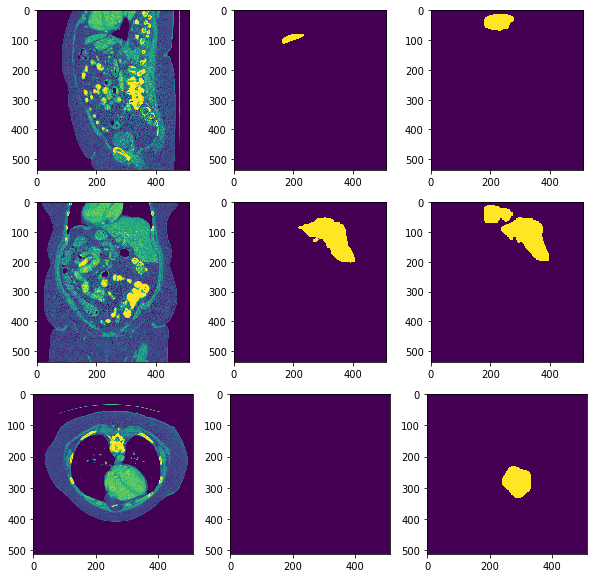

In [40]:
fg, ax = plt.subplots(3,3,figsize=(10,10))
h,w,d = original_mask_array.shape
best_slice_h = np.argmax(np.sum(np.abs(out_mask_image_original_space_array - original_mask_array), axis=(1,2)))
best_slice_w = np.argmax(np.sum(np.abs(out_mask_image_original_space_array - original_mask_array), axis=(0,2)))
best_slice_d = np.argmax(np.sum(np.abs(out_mask_image_original_space_array - original_mask_array), axis=(0,1,)))
ax[0,0].imshow(np.rot90(img_array[:,:,best_slice_d],2))
ax[1,0].imshow(np.rot90(img_array[:,best_slice_w ,:],2))
ax[2,0].imshow(img_array[best_slice_h,:,:])
ax[0,1].imshow(np.rot90(original_mask_array[:,:,best_slice_d],2))
ax[1,1].imshow(np.rot90(original_mask_array[:,best_slice_w ,:],2))
ax[2,1].imshow(original_mask_array[best_slice_h,:,:])
ax[0,2].imshow(np.rot90(out_mask_image_original_space_array[:,:,best_slice_d],2))
ax[1,2].imshow(np.rot90(out_mask_image_original_space_array[:,best_slice_w ,:],2))
ax[2,2].imshow(out_mask_image_original_space_array[best_slice_h,:,:])


In [ ]:
h, w,d = original_mask_array.shape
plt.imshow(original_mask_array[135,:,:])

In [ ]:
plt.imshow(data[0,145,:,:])

In [ ]:
plt.imshow(target["one_hot_target"][1,145,:,:])
# (target["one_hot_target"][1,:,:,:]==1)

In [ ]:
h, w,d = original_mask_array.shape
plt.imshow(original_mask_array[135,:,:])

In [ ]:
h, w,d = original_mask_array.shape
plt.imshow(original_mask_array[135,:,:])

In [ ]:
volume = output.cpu().numpy()[0,1,:,:,:]
image = data.cpu().numpy()[0,0,:,:,:]
volume = np.round(volume)
mask = target.cpu().numpy()[0,1,:,:,:]
intersection = np.sum(mask*volume)
union = np.sum(np.clip(mask+volume,0,1))
print(intersection)
print(union)
print(intersection/union)

In [ ]:
np.unique(volume)

In [ ]:
fg, ax = plt.subplots(3,1,figsize=(10,10))
h,w,d = mask.shape
ax[0].imshow(image[:,:,d//2])
ax[1].imshow(mask[:,:,d//2])
ax[2].imshow(volume[:,:,d//2])